### Learning tensorflow deeper than model.fit()

Experienced once the power of custom models in pytorch I wanted to impliment the same CapsNet-ish model in tensorflow. Fair enough, I did not suceed. At the time of writting the last trace is as follows:



```NotImplementedError: Cannot convert a symbolic Tensor (encoder_17/primary_caps_17/conv2d_33/BiasAdd:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported```

For now I simply have no time left to dig into the wood. Still I find it much more interesting than define vanila keras model than fit-predict. (I mean I can just Ctrl+C, Ctrl+V some of my github repo, that's not learning though). The model I tried to build is the same as I have build in model.py file, I hope at least my attempts will make your day :D

In [67]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
import tensorflow.keras.layers as layers
import tensorflow.keras.metrics as metrics
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [68]:
def load_mnist():
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    x_train = x_train/255
    x_test = x_test/255
    return x_train, y_train, x_test, y_test

In [69]:
x_train, y_train, x_test, y_test = load_mnist()

Text(0.5, 1.0, '3')

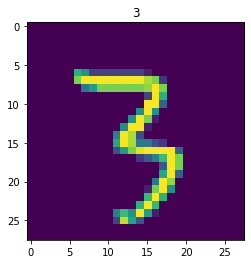

In [70]:
plt.imshow(x_train[44])
plt.title(y_train[44])

Text(0.5, 1.0, '3')

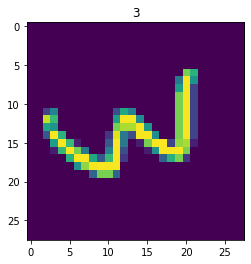

In [71]:
plt.imshow(np.rot90(x_train[44], 3))
plt.title(y_train[44])

In [72]:
class PrimaryCaps(Model):
    
    def __init__(self, num_capsules=2,
                 # in_channels=32, 
                 out_channels=16, 
                 kernel_size=9, 
                 num_routes=16*6*6):
        
        super().__init__()
        self.num_routes = num_routes
        self.capsule = layers.Conv2D(out_channels, 
                                     (kernel_size, kernel_size),
                                     strides=(2, 2))

    def call(self, x):
        print(x.shape)
        caps = [self.capsule(x) for _ in range(self.num_routes)]
        caps = np.stack(caps, axis=1)
        x = caps.reshape(
            caps.shape[0], self.num_routes, -1)
        return self.squash(x)
        
    
    def squash(self, x):
        v = (np.norm(x)**2/(
            1+np.norm(x)**2))*(x/np.norm(x))
        return v
        

In [73]:
class DigitCaps(Model):
    
    def __init__(self, num_capsules=10, 
                 num_routes=16*6*6, 
                 in_channels=2, out_channels=16):
        
        super().__init__()
        
        self.num_capsules = num_capsules
        self.num_routes = num_routes
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        # maybe?
        self.W = tf.Variable(np.random.randn(
            1, self.num_routes,
            self.num_capsules,
            self.out_channels,
            self.in_channels))
        
    def call(self, x):
        
        b_size = x.shape[0]
        
        x = np.stack(
            [x]*self.num_capsules, axis=2).expand_dims(4)
        W = np.concatenate([self.W]*b_size, axis=0)
        u_hat = tf.squeeze(np.dot(W, x))
        b_ij = tf.Variable(np.zeros(
            1, self.num_routes, self.num_capsules, 1))
        c_ij = tf.math.softplus(b_ij) #, dim=1)
        s_j = (c_ij*u_hat).sum(axis=1) #, keepdim=True)
        v_j = self.squash(s_j)
        
        return v_j.squeeze(1)

    def squash(self, x):
        v = (np.norm(x)**2/(
            1+np.norm(x)**2))*(x/np.norm(x))
        return v

In [74]:
class Encoder(Model):
    def __init__(self):
        
        super().__init__()
        
        self.conv_layer = layers.Conv2D(32, (9, 9), strides=(1, 1))
        self.primary_capsules = PrimaryCaps()
        self.digit_capsules = DigitCaps()
    
    def call(self, x):
        x = tf.nn.relu(self.conv_layer(x))
        x = self.primary_capsules(x)
        return self.digit_capsules(x)

In [75]:
def classifier(classes=10):
    return Sequential(layers.Flatten(),
                         layers.Dense(classes))

In [76]:
class CapsNetForClassification(Model):
    
    def __init__(self, num_classes=10): #, input_shape=(28, 28)):
        
        super().__init__()
        
        #self.input_shape = input_shape        
        self.encoder = Encoder()
        self.num_classes = num_classes
        self.classifier = classifier(10)
    
    def call(self, x):
        x = self.encoder(x)
        x = self.classifier(x)
        return x

In [78]:
model = CapsNetForClassification()
model.build(input_shape=(None, 28, 28, 1))

(None, 20, 20, 32)


NotImplementedError: in user code:

    <ipython-input-54-e8bae7a7bbb8>:12 call  *
        x = self.primary_capsules(x)
    <ipython-input-41-a94a1037fce7>:18 call  *
        caps = np.stack(caps, axis=1)
    <__array_function__ internals>:6 stack  **
        
    /opt/conda/lib/python3.7/site-packages/numpy/core/shape_base.py:420 stack
        arrays = [asanyarray(arr) for arr in arrays]
    /opt/conda/lib/python3.7/site-packages/numpy/core/shape_base.py:420 <listcomp>
        arrays = [asanyarray(arr) for arr in arrays]
    /opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:138 asanyarray
        return array(a, dtype, copy=False, order=order, subok=True)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:848 __array__
        " a NumPy call, which is not supported".format(self.name))

    NotImplementedError: Cannot convert a symbolic Tensor (encoder_17/primary_caps_17/conv2d_33/BiasAdd:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported


In [ ]:
model.compile(optimizer="adam",
    loss='categorical_crossentropy',
    metrics=['accuracy', metrics.Precision(), metrics.Recall()])
model.fit(x_train, y_train)